## Evaluate WoFSCast Performance 

In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from plot_params import target_vars, display_name_mapper, units_mapper

# Third-party
import xarray 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

## Time Series of RMSE for the Target Variables (Full Domain : Solid, In Convection: Dashed) 

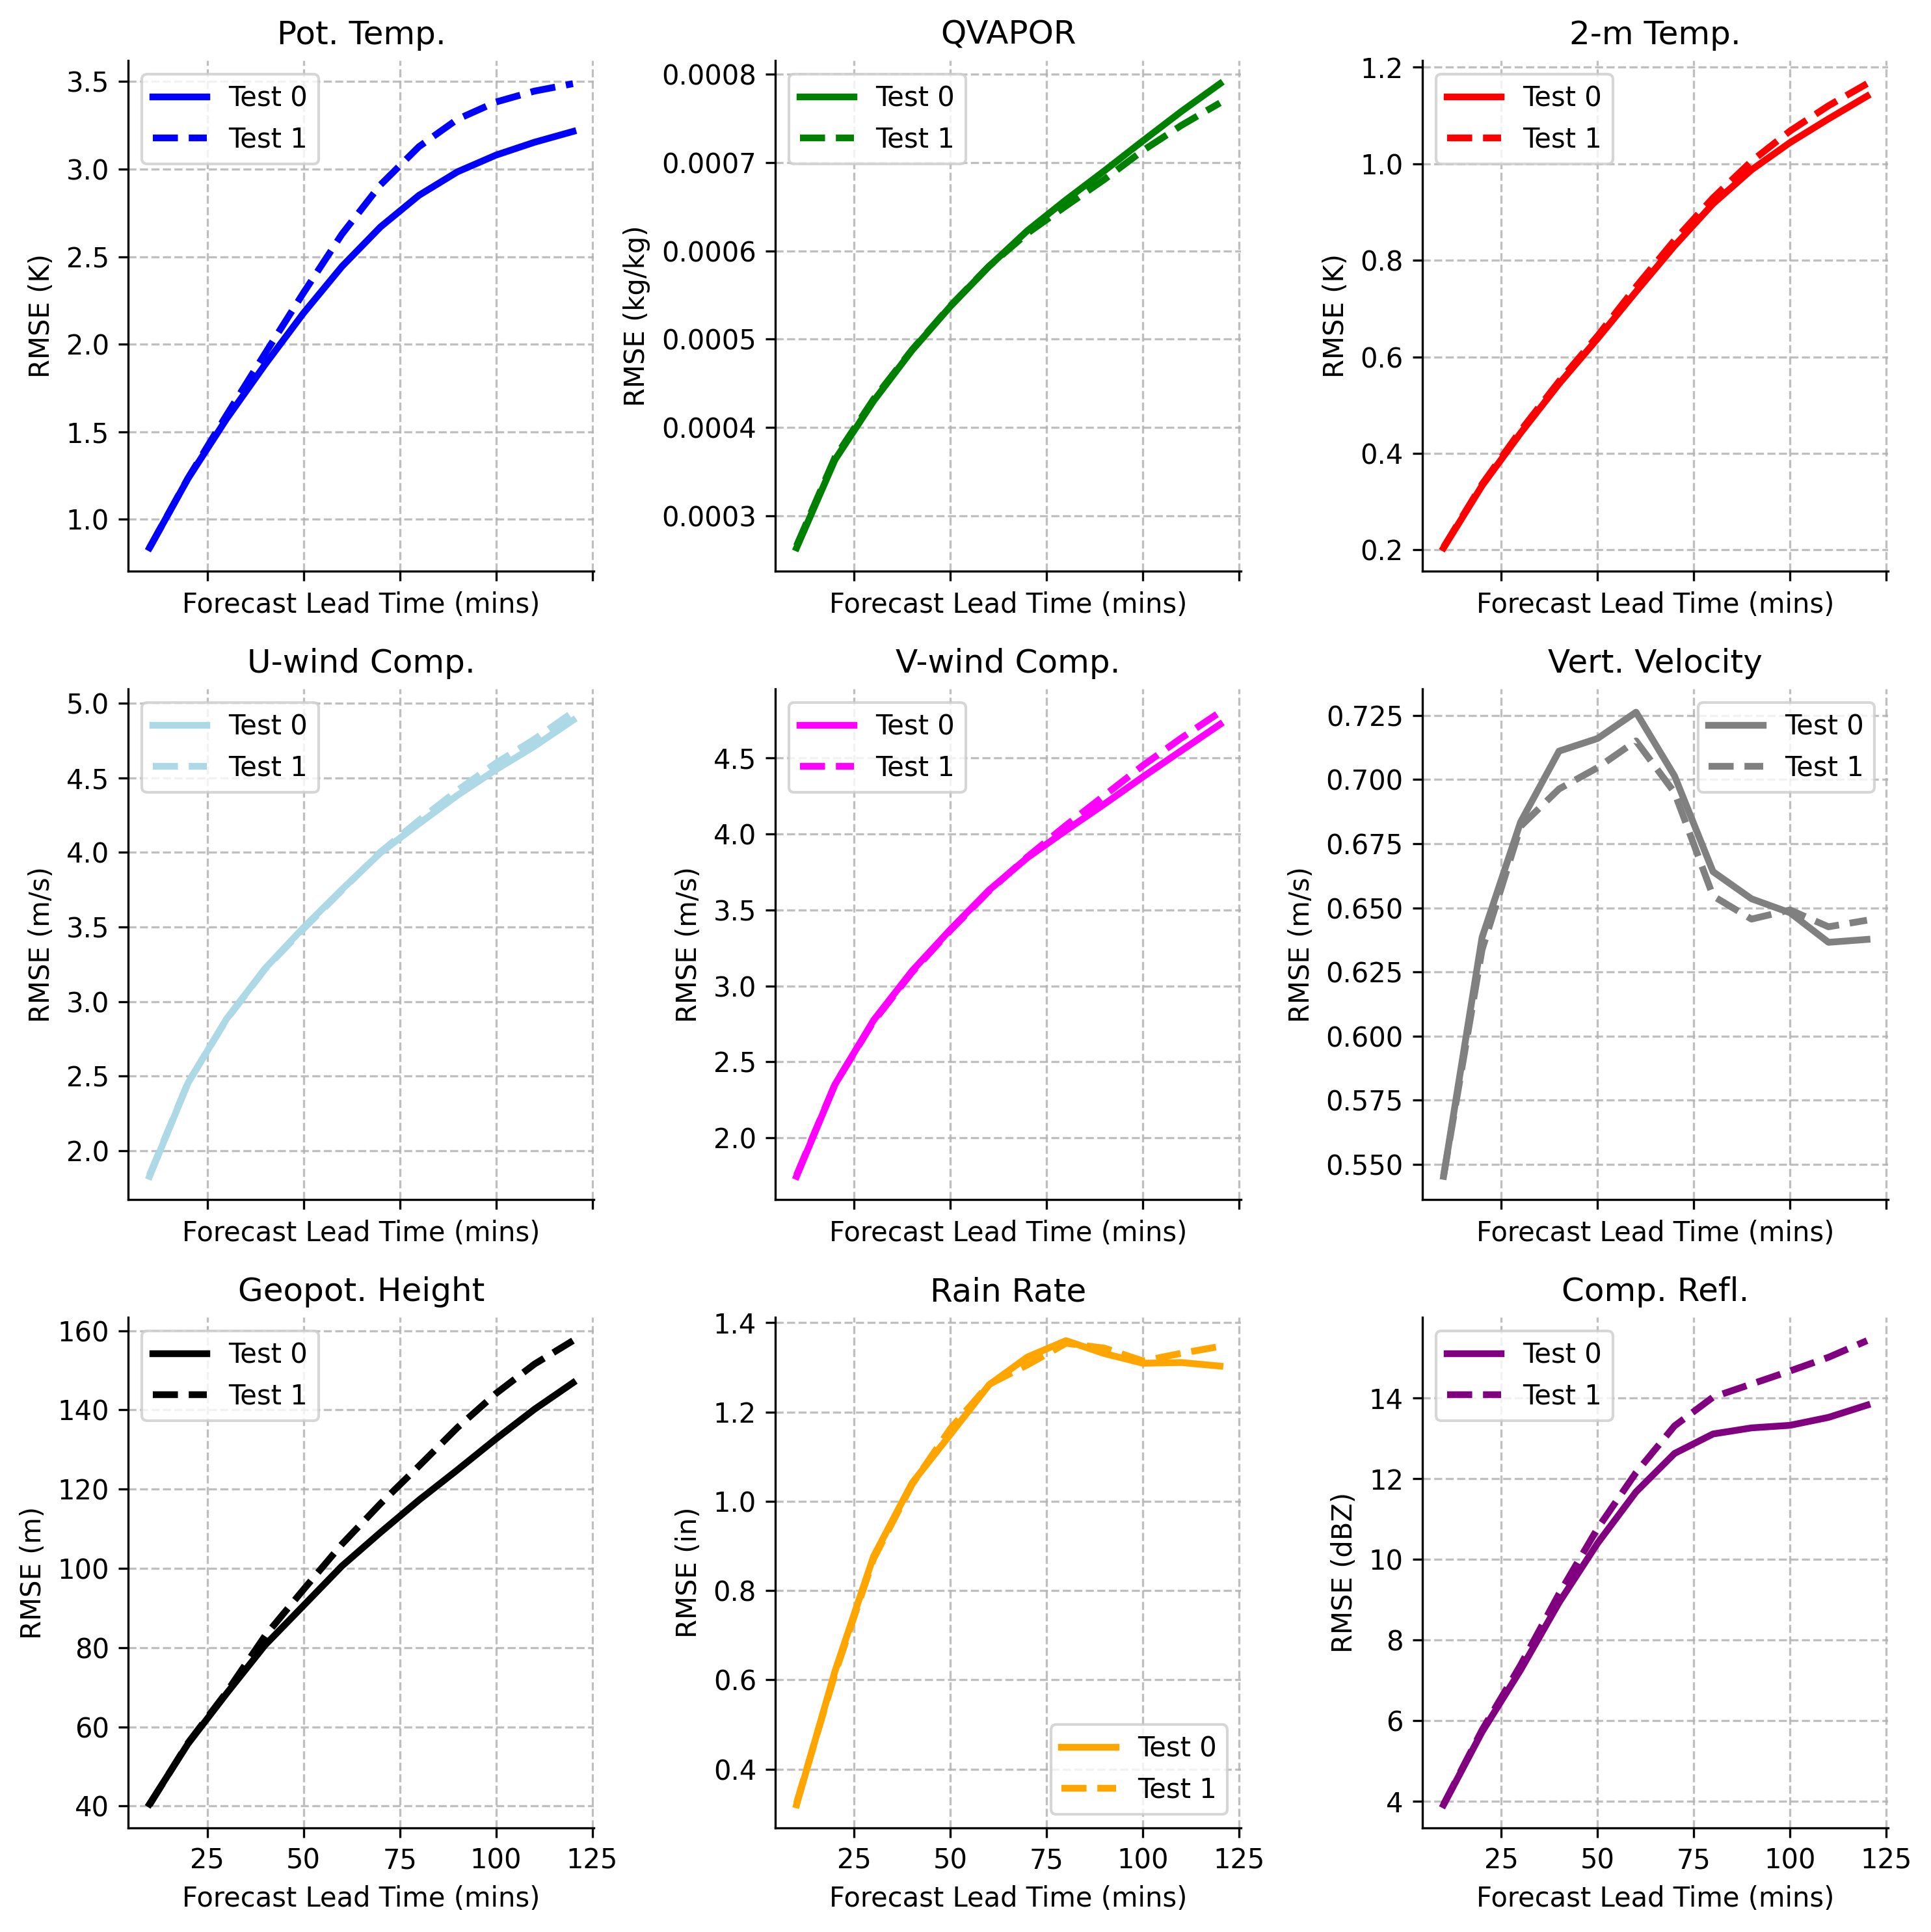

In [2]:
base_path = '/work/mflora/wofs-cast-data/verification_results'

#models = ['wofscast_baseline', 'wofscast_baseline_mlp']
#display_name = {'wofscast_baseline' : 'WoFSCast w/ Transformers', 
#                'wofscast_baseline_mlp' : 'WoFSCast w/ MLPs', 
#               }

models = [
          #'wofscast_reproducibility_test_v5',
          #'wofscast_reproducibility_test_v6', 
          #'wofscast_reproducibility_test_v7',
          'wofscast_reproducibility_test_seed_42',
           'wofscast_reproducibility_test_seed_123',
]

display_name = {
                'wofscast_reproducibility_test_seed_42' : 'Test 0', 
                'wofscast_reproducibility_test_seed_123' : 'Test 1', 

               }

variables = ['T', 'QVAPOR', 'T2', 
             'U', 'V', 'W',
             'GEOPOT', 'RAIN_AMOUNT', 'COMPOSITE_REFL_10CM'
            ]

rmse_dfs = [pd.read_parquet(os.path.join(base_path, f'MSE_{name}.parquet'), 
                            engine='pyarrow') for name in models]

# Get the time steps.

typ = 'Convective Regions'

times = rmse_dfs[0]['RMSE'][typ]['COMPOSITE_REFL_10CM'].index.total_seconds() / 60.0

fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']
line_styles = ['-', 'dashed', '-', '-']

for var, ax, c in zip(variables, axes.flat, colors): 
    for i in range(len(rmse_dfs)): 
        label = display_name.get(models[i], models[i])
        ax.plot(times, rmse_dfs[i]['RMSE'][typ][var], c=c, lw=2.5, label=label, ls=line_styles[i]) 
        #ax.plot(times, df['RMSE']['partial'][var], c=c, lw=2.5, ls='dashed')
    ax.legend()
    ax.set(xlabel= 'Forecast Lead Time (mins)', 
           ylabel= f"RMSE ({units_mapper.get(var,'')})", 
           title = display_name_mapper.get(var,var)
          )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
#plt.savefig(f"figures/MSE_{os.path.basename(MODEL_PATH).replace('.npz','')}.png")

## Time Series of POD, SR, CSI 

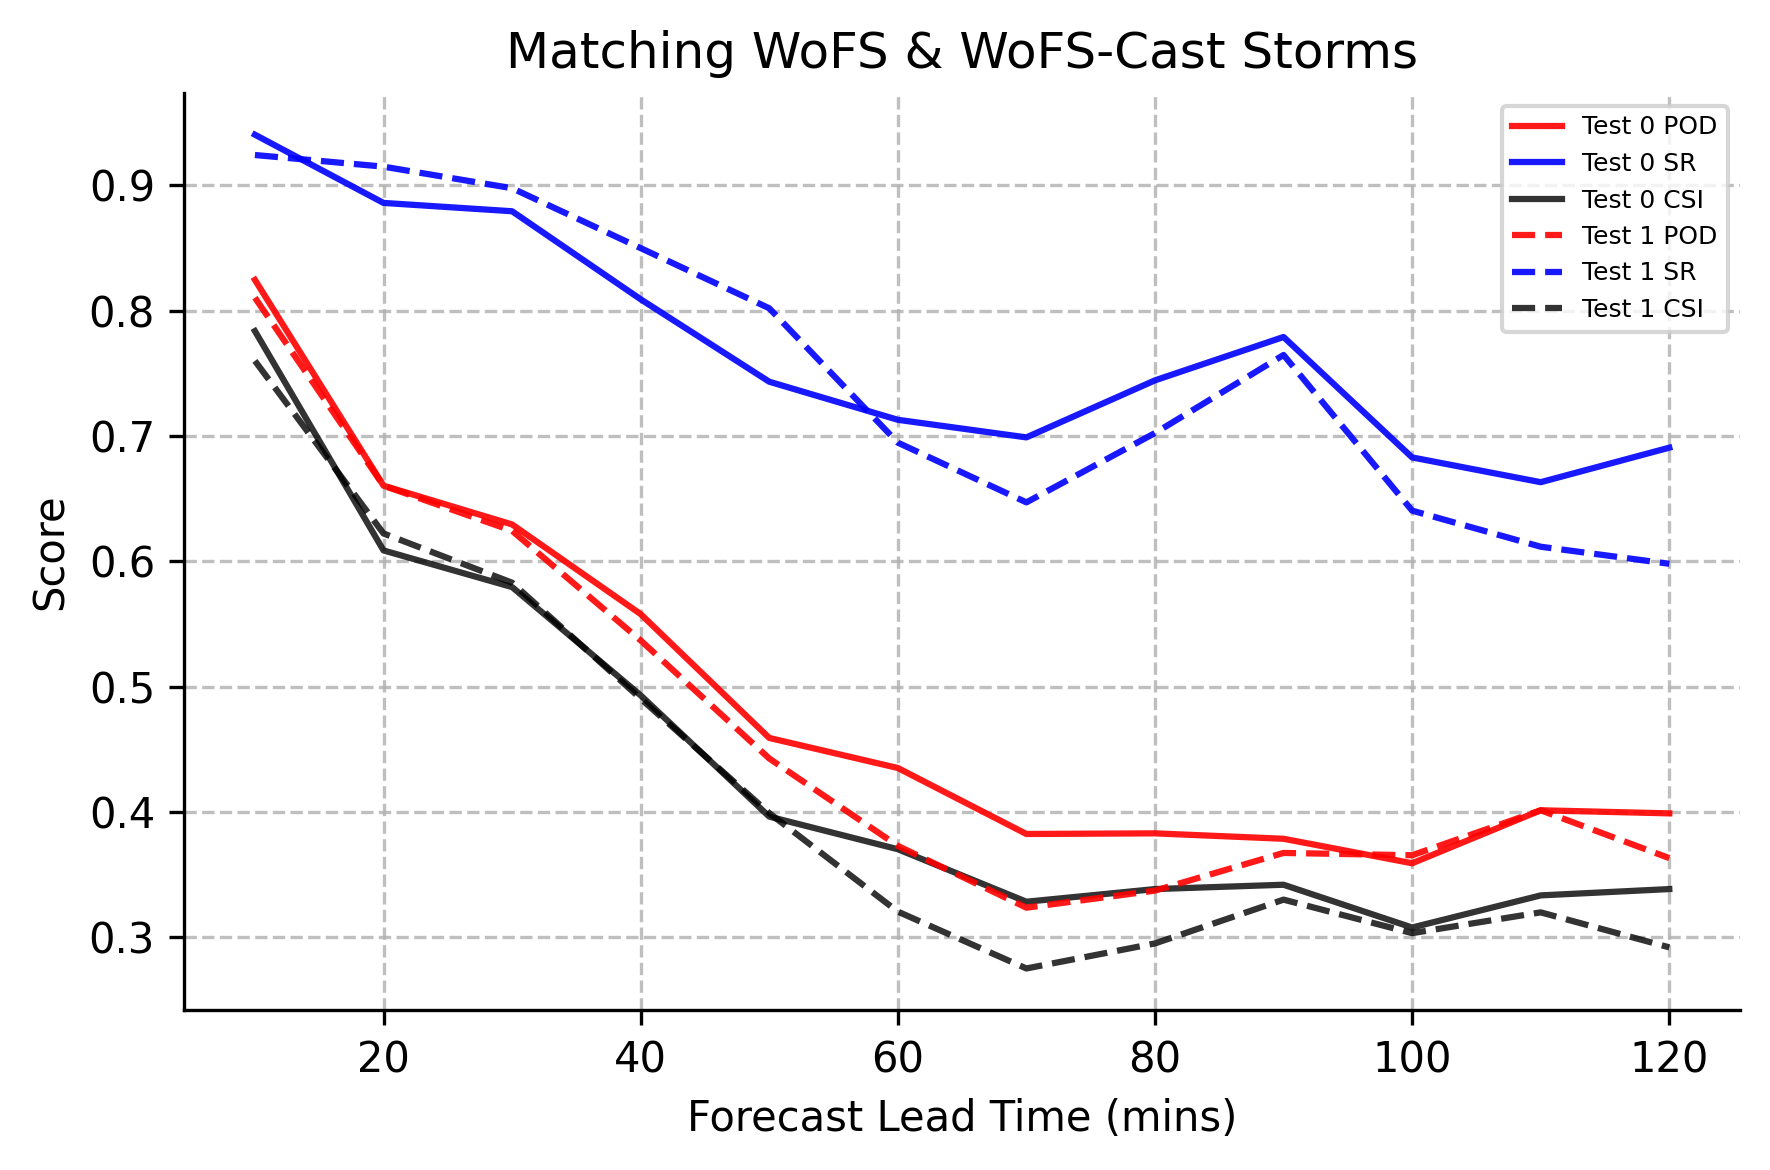

In [3]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300, )

object_dfs = [pd.read_json(os.path.join(base_path, f'objects_{name}.json')) for name in models]

for i in range(len(object_dfs)):
    label = display_name.get(models[i], models[i])
    pod_label = f'{label} POD'
    sr_label = f'{label} SR'
    csi_label = f'{label} CSI'
    
    ax.plot(times, object_dfs[i]['POD'], c='red', label=pod_label, ls=line_styles[i], lw=1.5, alpha=0.9)
    ax.plot(times, object_dfs[i]['SR'], c='blue', label=sr_label, ls=line_styles[i], lw=1.5, alpha=0.9)
    ax.plot(times, object_dfs[i]['CSI'], c='black', label=csi_label, ls=line_styles[i], lw=1.5, alpha=0.8)

ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS & WoFS-Cast Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.legend(fontsize=6)
    
plt.tight_layout()
#plt.savefig(f"figures/ObjectsVerify_{os.path.basename(MODEL_PATH).replace('.npz','')}.png")